In [1]:
import os
import sys
import re
import matplotlib

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import matplotlib.colors as colors

from scipy.stats     import rankdata
from matplotlib      import cm
from ast             import literal_eval
from sklearn.metrics import mean_squared_error
from functools       import reduce

sys.path.append('../../docs/')

from feynman_equations import original_expressions, original_lambdas, datasets, representable

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1000)

# Setting the configurations to retrieve processed data

In [5]:
groundtruth_method   = 'SHAP' #['SHAP', 'gradient']
explainers           = ['PE', 'PE_adj', 'SHAP', 'SHAP_adj', 'LIME', 'GINI']  # we'll try to retrieve data from the explainers listed
reps                 = 30
normalization_method = 'ExErr' #['ExErr', 'None', 'AbsMax']

# Loading processed data and removing invalid explainers

When we use gradients of the original function as the ground truth, the calculations and adjustments made to Partial Effects explainer with ITEA algorithm doesn't try to approximate the ground truth correctly (due to the adjustment step), so we'll remove them from the plots in order to obtain a clearer visualization. This is also the case for SHAP.

Otherwise, when considering that SHAP is the ground truth, then the PE doesn't try to approximate it correctly (due to the adjustment step), as well as SHAP_adj. So they are removed. 

The cell below does this selection of exlainers.

In [6]:
feynman_info = pd.read_csv('../../docs/FeynmanEquations.csv')

df_merged = pd.read_csv(f'../../results/tabular_processed/processed_results-{groundtruth_method}-{normalization_method}.csv')

if groundtruth_method == 'gradient':
    
    df_merged = df_merged.drop(
        [c for c in df_merged.columns if re.match(r'^(Global|Local)-(SHAP-|ME_adj-)', c)], axis=1)
elif groundtruth_method == 'SHAP':
    
    df_merged = df_merged.drop(
        [c for c in df_merged.columns if re.match(r'^(Global|Local)-(ME-|SHAP_adj-|LIME-)', c)], axis=1)
    
print(df_merged.columns)

Index(['Dataset', 'Global-PE-ITEA', 'Global-PE_adj-ITEA', 'Global-SHAP-ITEA',
       'Global-SHAP-KR', 'Global-SHAP-RF', 'Global-SHAP-XGB', 'Local-PE-ITEA',
       'Local-PE_adj-ITEA', 'Local-SHAP-ITEA', 'Local-SHAP-KR',
       'Local-SHAP-RF', 'Local-SHAP-XGB', 'RMSE-test-ITEA', 'RMSE-test-KR',
       'RMSE-test-RF', 'RMSE-test-XGB', 'RMSE-train-ITEA', 'RMSE-train-KR',
       'RMSE-train-RF', 'RMSE-train-XGB', 'Tottime-train-ITEA',
       'Tottime-train-KR', 'Tottime-train-RF', 'Tottime-train-XGB'],
      dtype='object')


Local n_best


,Dataset,Local-PE-ITEA,Local-PE_adj-ITEA,Local-SHAP-ITEA,Local-SHAP-KR,Local-SHAP-RF,Local-SHAP-XGB
90,III.15.14,0.937484,0.650852,0.0,0.256903,0.451234,0.430750
5,I.12.4,0.787762,0.552287,0.0,0.311870,0.268980,0.303794
79,II.4.23,1.036036,0.370627,0.0,0.189396,0.526365,0.337967
67,II.3.24,0.320000,0.250000,0.0,0.080000,0.047000,0.058667
84,II.8.7,0.968855,0.385355,0.0,0.234596,0.303584,0.354204


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high,v4_name,v4_low,v4_high,v5_name,v5_low,v5_high,v6_name,v6_low,v6_high,v7_name,v7_low,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
9,I.12.4,11,Ef,q1*r/(4*pi*epsilon*r**3),3,q1,1,5,epsilon,1.0,5.0,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,II.3.24,53,flux,Pwr/(4*pi*r**2),2,Pwr,1,5,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,II.4.23,54,Volt,q/(4*pi*epsilon*r),3,q,1,5,epsilon,1.0,5.0,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,II.8.7,58,E_n,3/5*q**2/(4*pi*epsilon*d),3,q,1,5,epsilon,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,III.15.14,96,m,(h/(2*pi))**2/(2*E_n*d**2),3,h,1,5,E_n,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


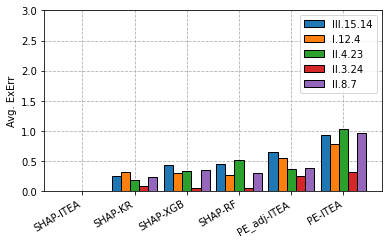

Local n_worst


,Dataset,Local-PE-ITEA,Local-PE_adj-ITEA,Local-SHAP-ITEA,Local-SHAP-KR,Local-SHAP-RF,Local-SHAP-XGB
99,III.9.52,2.195003,1.759222,1.190722,1.153258,1.973116,1.617534
3,I.12.11,1.294536,1.013670,0.619463,0.511714,0.895169,0.815740
93,III.19.51,1.644673,1.253495,0.314372,0.848393,1.118317,1.036182
16,I.18.14,1.071084,0.533480,0.219759,0.352185,0.736186,0.774780
89,III.15.12,1.006797,0.902359,0.425414,0.931078,0.872602,0.860373


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high,v4_name,v4_low,v4_high,v5_name,v5_low,v5_high,v6_name,v6_low,v6_high,v7_name,v7_low,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
11,I.12.11,13,F,q*(Ef+B*v*sin(theta)),5,q,1,5,Ef,1.0,5.0,B,1.0,5.0,v,1.0,5.0,theta,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,I.18.14,23,L,m*r*v*sin(theta),4,m,1,5,r,1.0,5.0,v,1.0,5.0,theta,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,III.9.52,90,prob,(p_d*Ef*t/(h/(2*pi)))*sin((omega-omega_0)*t/2)**2/((omega-omega_0)*t/2)**2,6,p_d,1,3,Ef,1.0,3.0,t,1.0,3.0,h,1.0,3.0,omega,1.0,5.0,omega_0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,III.15.12,95,E_n,2*U*(1-cos(k*d)),3,U,1,5,k,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,III.19.51,99,E_n,-m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1/n**2),5,m,1,5,q,1.0,5.0,h,1.0,5.0,n,1.0,5.0,epsilon,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


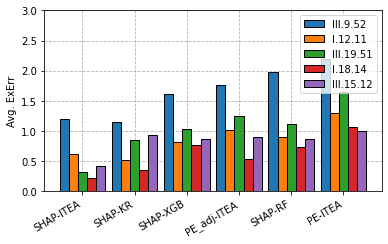

Global n_best


,Dataset,Global-PE-ITEA,Global-PE_adj-ITEA,Global-SHAP-ITEA,Global-SHAP-KR,Global-SHAP-RF,Global-SHAP-XGB
90,III.15.14,0.273130,0.237206,0.0,0.106771,0.159106,0.108430
5,I.12.4,0.064807,0.151217,0.0,0.066833,0.179135,0.179916
79,II.4.23,0.043205,0.082865,0.0,0.088318,0.321822,0.090921
67,II.3.24,0.120000,0.080000,0.0,0.020000,0.016000,0.017333
84,II.8.7,0.390640,0.219697,0.0,0.008165,0.115987,0.160887


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high,v4_name,v4_low,v4_high,v5_name,v5_low,v5_high,v6_name,v6_low,v6_high,v7_name,v7_low,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
9,I.12.4,11,Ef,q1*r/(4*pi*epsilon*r**3),3,q1,1,5,epsilon,1.0,5.0,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,II.3.24,53,flux,Pwr/(4*pi*r**2),2,Pwr,1,5,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,II.4.23,54,Volt,q/(4*pi*epsilon*r),3,q,1,5,epsilon,1.0,5.0,r,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,II.8.7,58,E_n,3/5*q**2/(4*pi*epsilon*d),3,q,1,5,epsilon,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,III.15.14,96,m,(h/(2*pi))**2/(2*E_n*d**2),3,h,1,5,E_n,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


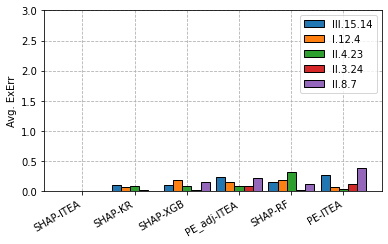

Global n_worst


,Dataset,Global-PE-ITEA,Global-PE_adj-ITEA,Global-SHAP-ITEA,Global-SHAP-KR,Global-SHAP-RF,Global-SHAP-XGB
99,III.9.52,0.656979,1.191428,0.338563,0.204613,1.073833,0.464308
3,I.12.11,0.364674,0.667682,0.112276,0.074027,0.473207,0.244122
93,III.19.51,0.336881,0.373736,0.096439,0.067823,0.500764,0.446395
16,I.18.14,0.359434,0.290229,0.044731,0.030000,0.036187,0.129773
89,III.15.12,0.349513,0.507054,0.071695,0.445047,0.381392,0.320929


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high,v4_name,v4_low,v4_high,v5_name,v5_low,v5_high,v6_name,v6_low,v6_high,v7_name,v7_low,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
11,I.12.11,13,F,q*(Ef+B*v*sin(theta)),5,q,1,5,Ef,1.0,5.0,B,1.0,5.0,v,1.0,5.0,theta,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,I.18.14,23,L,m*r*v*sin(theta),4,m,1,5,r,1.0,5.0,v,1.0,5.0,theta,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,III.9.52,90,prob,(p_d*Ef*t/(h/(2*pi)))*sin((omega-omega_0)*t/2)**2/((omega-omega_0)*t/2)**2,6,p_d,1,3,Ef,1.0,3.0,t,1.0,3.0,h,1.0,3.0,omega,1.0,5.0,omega_0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,III.15.12,95,E_n,2*U*(1-cos(k*d)),3,U,1,5,k,1.0,5.0,d,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,III.19.51,99,E_n,-m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1/n**2),5,m,1,5,q,1.0,5.0,h,1.0,5.0,n,1.0,5.0,epsilon,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


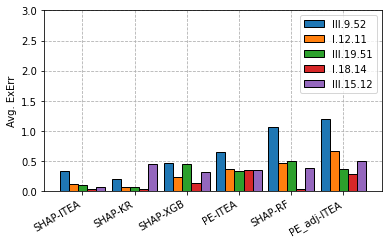

In [7]:
for scope in ['Local', 'Global']:
    for performance in ['n_best', 'n_worst']:
        print(scope, performance)
        
        fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

        combinations = np.array([c for c in df_merged.columns if scope in c])

        # Finding the cases
        selected = None
        xlabels  = None
        if performance == 'n_best':
            # Displaying the equations and performances
            display(df_merged.nsmallest(5, f'RMSE-test-ITEA')[['Dataset']+list(combinations)])
            display(feynman_info[feynman_info['Filename'].isin(df_merged.nsmallest(5, f'RMSE-test-ITEA')['Dataset'])])
            
            xlabels = df_merged.nsmallest(5, f'RMSE-test-ITEA')['Dataset'].values
            selected = df_merged.nsmallest(5, f'RMSE-test-ITEA')[combinations].values
            
        else:
            display(df_merged.nlargest(5, f'RMSE-test-ITEA')[['Dataset']+list(combinations)])
            display(feynman_info[feynman_info['Filename'].isin(df_merged.nlargest(5, f'RMSE-test-ITEA')['Dataset'])])
            
            xlabels = df_merged.nlargest(5, f'RMSE-test-ITEA')['Dataset'].values
            selected = df_merged.nlargest(5, f'RMSE-test-ITEA')[combinations].values
            
        order = np.argsort(np.mean(selected, axis=0))
        
        ax.set_xticks(range(len(combinations)))
        ax.set_xticklabels(
            [l.replace(f'{scope}-', '') for l in combinations[order]],
            rotation = 30, ha='right')

        # Creating one bar for each dataset
        for idx, pos in enumerate([-0.350, -0.175, 0.0, 0.175, 0.350]):
            ax.bar(
                np.array(range(len(combinations)))+pos,
                selected[idx, order],
                width=0.175,
                label=xlabels[idx],
                edgecolor='black',
                lw=1,
                color=sns.color_palette(n_colors=5)[idx]
            )
            
        ax.grid(zorder=-10, ls='--')
        ax.set_axisbelow(True)

        ax.set_ylim([None,3.0])
    
        ax.legend(loc=1)
        ax.set_ylabel(f'Avg. ExErr')
        
        plt.tight_layout()
        plt.savefig(f'../../results/figures/{scope}Cases-{groundtruth_method}-{normalization_method}-{performance}.pdf')
        plt.show()